# Task
Our task is simple, recognize handwritten digits. We will use MNIST dataset for this tutorial.


# Import necessary library
In this tutorial, we are going to use pytorch, the cutting-edge deep learning framework to complete our task.

In [4]:
import torch
import torchvision

In [5]:
## Create dataloader, in PyTorch, we feed the trainer data with use of dataloader
## We create dataloader with dataset from torchvision, 
## and we dont have to download it seperately, all automatically done

# Define batch size, batch size is how much data you feed for training in one iteration
batch_size_train = 64 # We use a small batch size here for training
batch_size_test = 1024 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
#image datasets
train_dataset = torchvision.datasets.MNIST('dataset/', 
                                           train=True, 
                                           download=True,
                                           transform=image_transform)
test_dataset = torchvision.datasets.MNIST('dataset/', 
                                          train=False, 
                                          download=True,
                                          transform=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True)

Label: tensor(6)


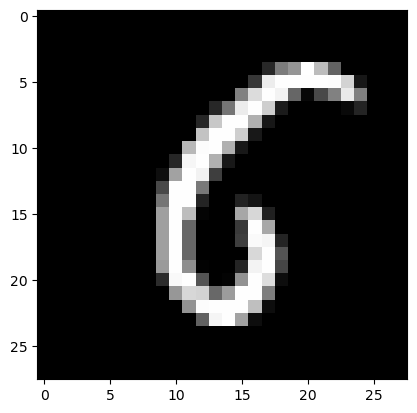

In [6]:
# import library
import matplotlib.pyplot as plt
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))
sample = example_datas[0][0]
# show the data
plt.imshow(sample, cmap='gray', interpolation='none')
print("Label: "+ str(labels[0]))

In [7]:
## Now we can start to build our CNN model
## We first import the pytorch nn module and optimizer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
## Then define the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #input channel 1, output channel 10
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1)
        #input channel 10, output channel 20
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1)
        #dropout layer
        self.conv2_drop = nn.Dropout2d()
        #fully connected layer
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
## create model and optimizer
learning_rate = 0.01
momentum = 0.5
device = "cpu"
model = CNN().to(device) #using cpu here
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

In [9]:
from tqdm import tqdm_notebook as tqdm
##define train function
def train(model, device, train_loader, optimizer, epoch, log_interval=10000):
    model.train()
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    for batch_idx, (data, target) in enumerate(tk0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        counter += 1
        tk0.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))
##define test function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [10]:
num_epoch = 7
for epoch in range(1, num_epoch + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

/tmp/ipykernel_579/1895196525.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tk0 = tqdm(train_loader, total=int(len(train_loader)))


  0%|          | 0/938 [00:00<?, ?it/s]

/tmp/ipykernel_579/4020281764.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Average loss: 0.3433, Accuracy: 8962/10000 (90%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.2232, Accuracy: 9351/10000 (94%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1872, Accuracy: 9466/10000 (95%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1603, Accuracy: 9542/10000 (95%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1358, Accuracy: 9584/10000 (96%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1299, Accuracy: 9631/10000 (96%)



  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1196, Accuracy: 9637/10000 (96%)



In [11]:
# from torchsummary import summary
# summary(model, (1, 28, 28))

In [43]:
# dummy torch save model
torch.save(model, "./models/dummy_model.pt")

# idempotent register (register + upload)

In [49]:
from minio import Minio
from model_registry import ModelRegistry
from typing import Any

In [45]:
minio_client = Minio("minio-service.kubeflow.svc.cluster.local:9000",
    access_key="minio",
    secret_key="minio123",
    secure=False  # only when you use http
)

In [46]:
registry = ModelRegistry(
    server_address="http://model-registry-service.kubeflow-user-example-com.svc.cluster.local",
    port=8080,
    author="joel",
    is_secure=False  # Set to True if your Model Registry uses HTTPS
)

In [65]:
def upload(client, source, destination, bucket_name='models') -> (str, str):
    # return (bucket, object string) if successful
    # upload file into bucket
    source_file = source
    destination_file = destination

    found = client.bucket_exists(bucket_name)
    if not found:
        client.make_bucket(bucket_name)
        print('Created bucket', bucket_name)
    else:
        print('Bucket', bucket_name, 'already exists')

    client.fput_object(bucket_name, destination_file, source_file)
    print(source_file, 'successfully uploaded as object', destination_file, 'to bucket', bucket_name)
    return bucket_name, destination
    

In [50]:
def register(registry, name, path, version, **kwargs) -> Any:
    registry.register_model(name, path, model_format_name=kwargs.get('model_format_name', 'pytorch'), model_format_version=kwargs.get('model_format_version', '1'), version=version, description=kwargs.get('description', None), metadata=kwargs.get('metadata'))
    return registry

In [70]:
def upload_reg(client, source, destination, registry, name, version, **kwargs) -> Any:
    # if success return registry

    bucket_name='models'
    try:
        upload(client, source, destination, bucket_name=bucket_name)
    except Exception as e:
        try:
            client.remove_object(bucket_name, destination)
        except:
            print('Unexpected error in upload and remove')
        finally:
            print('Unexpected error in upload')
            return

    try:
        return register(registry, name, f'{bucket_name}/{destination}', version, **kwargs)
    except:
        try:
            client.remove_object(bucket_name, destination)
        except:
            print('Unexpected error in register and remove')
        finally:
            print('Unexpected error in register')
            return
            

In [71]:
# upload(minio_client, './models/dummy_model.pt', 'pytorch/dummy_model.pt', bucket_name='models')

In [75]:
reg = upload_reg(minio_client, './models/dummy_model.pt', 'pytorch/dummy_model.pt', registry, 'mnist', 'v4')

Bucket models already exists
./models/dummy_model.pt successfully uploaded as object pytorch/dummy_model.pt to bucket models


In [19]:
# model = reg.get_registered_model("mnist")
# print("Registered Model:", model, "with ID", model.id)

Registered Model: name='mnist' id='1' description=None external_id=None create_time_since_epoch='1761864364342' last_update_time_since_epoch='1761864364342' custom_properties=None owner='joel' state=<RegisteredModelState.LIVE: 'LIVE'> with ID 1
